<a href="https://colab.research.google.com/github/AhsanFarooq00/Innovative_Deep_Learning_Models_for_Brain_Tumor_Diagnosis-/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance, ImageOps
from tensorflow.keras.preprocessing.image import load_img
# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

# Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/MRI Brain Tumor Dataset/Training/'
test_dir = '/content/drive/MyDrive/MRI Brain Tumor Dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Distribution Of Image Data

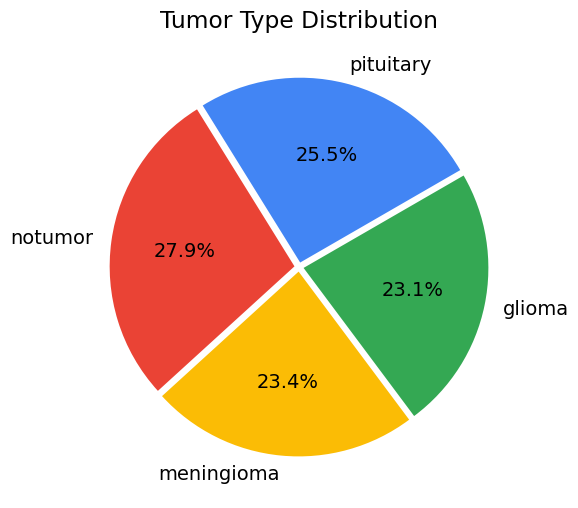

In [ ]:
def plot_tumor_distribution(train_labels):
    plt.figure(figsize=(8, 6))
    colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
    plt.rcParams.update({'font.size': 14})

    labels = ['pituitary', 'notumor', 'meningioma', 'glioma']
    sizes = [len([x for x in train_labels if x == label]) for label in labels]

    plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%',
            explode=(0.025, 0.025, 0.025, 0.025), startangle=30)

    plt.title('Tumor Type Distribution')
    plt.show()

plot_tumor_distribution(train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

**Distribution of Data in training and testing**

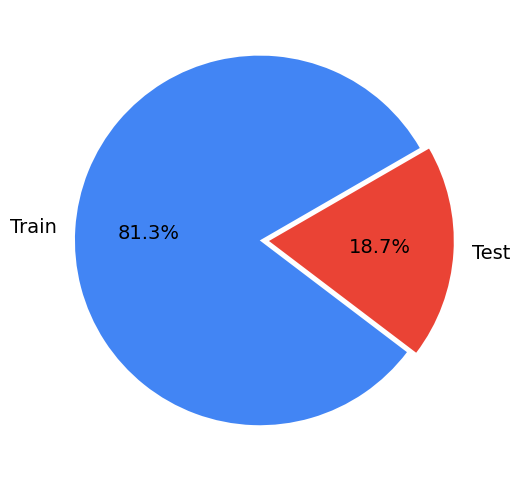

In [ ]:
plt.figure(figsize=(8,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# Data Augmentation

In [ ]:
def augment_image(image):
    # Convert the image to a PIL Image
    image = Image.fromarray(np.uint8(image))

    # Brightness adjustment
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))

    # Contrast adjustment
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

    # Sharpness adjustment
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8, 1.2))

    # Color adjustment
    image = ImageEnhance.Color(image).enhance(random.uniform(0.8, 1.2))

    # Random horizontal flip
    if random.random() > 0.5:
        image = ImageOps.mirror(image)

    # Random vertical flip
    if random.random() > 0.5:
        image = ImageOps.flip(image)

    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-15, 15)
        image = image.rotate(angle, resample=Image.BICUBIC, expand=True)

    # Random translation
    if random.random() > 0.5:
        max_dx = 10
        max_dy = 10
        dx = random.uniform(-max_dx, max_dx)
        dy = random.uniform(-max_dy, max_dy)
        image = image.transform(image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy), resample=Image.BICUBIC)

    # Resize image back to target size
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BICUBIC)

    # Convert the image back to a numpy array and normalize to [0,1]
    image = np.array(image) / 255.0

    return image

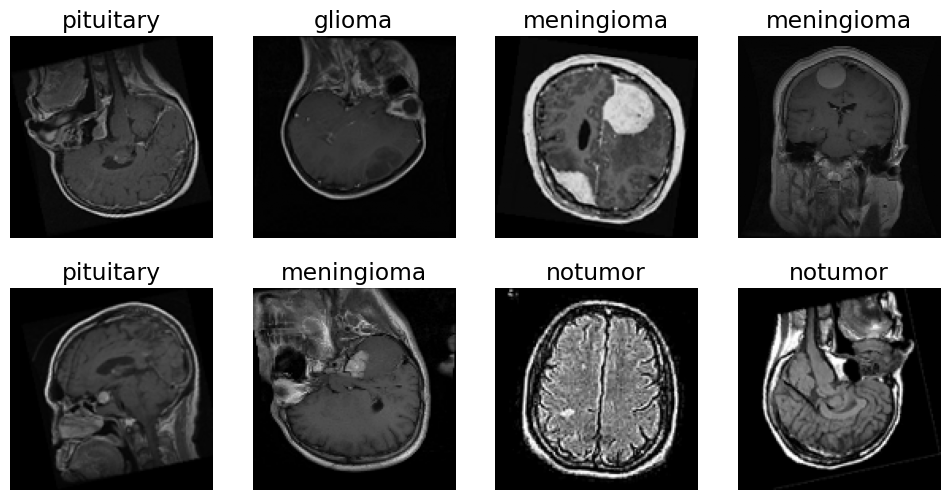

In [ ]:
IMAGE_SIZE = 128

def load_and_augment_images(image_paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    augmented_images = []
    for path in image_paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        augmented_images.append(image)
    return np.array(augmented_images)

augmented_images = load_and_augment_images(train_paths[50:59])
sample_labels = train_labels[50:59]

fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1)
    ax.axis('off')
    ax.set_title(sample_labels[i])
    ax.imshow(augmented_images[i])

plt.rcParams.update({'font.size': 12})
plt.show()
